# Homework: Sonar signal classification
In this workshop you will train a binary classification neural network to differentiate if sonar signals bounced against a metal cylinder or a rock.

[Info of the data](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

Goal: Get an accuracy higher than 0.80 in the validation set

## Get the data from Google Drive

In [23]:
# Import libraries to interact with Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [24]:
# Authenticate with your Google account to get access to the data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [25]:
# Download data
download = drive.CreateFile({'id': '1rw5l3jCo2vlNc8NLrMk3KPZr6HsjNRCY'})
download.GetContentFile('sonar.csv')

In [26]:
ls

sample_data/  sonar.csv


## Do some magic below! ;)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
# Cargar los datos
data = pd.read_csv('sonar.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [29]:
# Calcular los valores mínimos y máximos para cada característica para examinar el rango de valores
range_stats = data.describe().loc[['min', 'max']]
range_stats

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
min,0.0015,0.0006,0.0015,0.0058,0.0067,0.0102,0.0033,0.0055,0.0075,0.0113,...,0.0000,0.0008,0.0005,0.0010,0.0006,0.0004,0.0003,0.0003,0.0001,0.0006
max,0.1371,0.2339,0.3059,0.4264,0.4010,0.3823,0.3729,0.4590,0.6828,0.7106,...,0.1004,0.0709,0.0390,0.0352,0.0447,0.0394,0.0355,0.0440,0.0364,0.0439


In [30]:
# Separar características y etiquetas
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Codificar las etiquetas (M para metal, R para roca)
y = np.where(y == 'M', 1, 0)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [31]:
# Crear un nuevo DataFrame para las características escaladas (solo para visualizar)
scaled_data = pd.DataFrame(X_train)
scaled_data.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.412569,0.000871,1.733748,0.817630,-0.972942,-0.956700,0.312602,0.695788,0.064470,-0.201801,...,-0.151489,-0.394444,-1.061345,0.079350,-0.894390,-0.469589,0.258466,-0.352895,-0.133623,-0.797984
1,-0.416925,-0.079822,-0.760921,-0.910844,-0.687322,0.988321,1.286011,0.368363,0.454054,0.449789,...,0.338868,-0.154637,-0.072748,1.296102,-0.850330,0.418061,-0.200710,0.648777,1.952671,1.831159
2,0.371428,0.111824,-0.287410,-0.600947,0.159622,0.497808,-0.111249,-0.845935,-1.406530,-1.166571,...,-0.846161,-0.415296,0.870222,0.744319,-0.145364,-0.207329,1.084983,-0.180193,0.033280,0.071808
3,0.550005,0.172344,0.526137,-1.036405,-1.103851,-0.052316,-0.283691,-0.366575,0.431792,0.134384,...,-0.396667,-1.072158,-1.015717,-0.033837,0.427421,0.135627,-0.274178,-0.283814,-0.767857,0.269488
4,1.042181,0.226140,-0.722786,-0.603619,-0.770628,0.206566,0.043465,-0.239374,-0.462110,0.334759,...,-0.053417,0.304124,-1.122182,-0.797844,-0.424413,0.175975,1.176818,1.045992,0.016590,-0.659608


In [32]:
# Construir la red neuronal
model = Sequential([
    Dense(64, input_dim=60, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Configurar el callback ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [34]:
# Entrenar el modelo con el callback ModelCheckpoint
history = model.fit(X_train, y_train, epochs=65, batch_size=10, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/65
10/17 [================>.............] - ETA: 0s - loss: 0.9348 - accuracy: 0.4300 
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to best_model.h5
17/17 [==============================] - 2s 30ms/step - loss: 0.9116 - accuracy: 0.4277 - val_loss: 0.5606 - val_accuracy: 0.7143
Epoch 2/65
 1/17 [>.............................] - ETA: 0s - loss: 1.1200 - accuracy: 0.6000
Epoch 2: val_accuracy improved from 0.71429 to 0.76190, saving model to best_model.h5
17/17 [==============================] - 0s 7ms/step - loss: 0.8874 - accuracy: 0.4759 - val_loss: 0.5266 - val_accuracy: 0.7619
Epoch 3/65
 1/17 [>.............................] - ETA: 0s - loss: 0.6710 - accuracy: 0.6000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/17 [=======================>......] - ETA: 0s - loss: 0.7587 - accuracy: 0.5643
Epoch 3: val_accuracy did not improve from 0.76190
17/17 [==============================] - 0s 7ms/step - loss: 0.7615 - accuracy: 0.5783 - val_loss: 0.5164 - val_accuracy: 0.7381
Epoch 4/65
 1/17 [>.............................] - ETA: 0s - loss: 0.8040 - accuracy: 0.5000
Epoch 4: val_accuracy did not improve from 0.76190
17/17 [==============================] - 0s 6ms/step - loss: 0.6650 - accuracy: 0.5904 - val_loss: 0.5122 - val_accuracy: 0.7143
Epoch 5/65
 1/17 [>.............................] - ETA: 0s - loss: 0.5735 - accuracy: 0.7000
Epoch 5: val_accuracy did not improve from 0.76190
17/17 [==============================] - 0s 7ms/step - loss: 0.6121 - accuracy: 0.6687 - val_loss: 0.4911 - val_accuracy: 0.7619
Epoch 6/65
13/17 [=====================>........] - ETA: 0s - loss: 0.5928 - accuracy: 0.6231
Epoch 6: val_accuracy did not improve from 0.76190
17/17 [==============================] - 0s 

In [35]:
# Cargar el mejor modelo guardado
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluar el mejor modelo
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Precisión del Mejor Modelo en la Validación: {val_accuracy}')


2/2 [==============================] - 0s 11ms/step - loss: 0.3019 - accuracy: 0.9286
Precisión del Mejor Modelo en la Validación: 0.9285714030265808


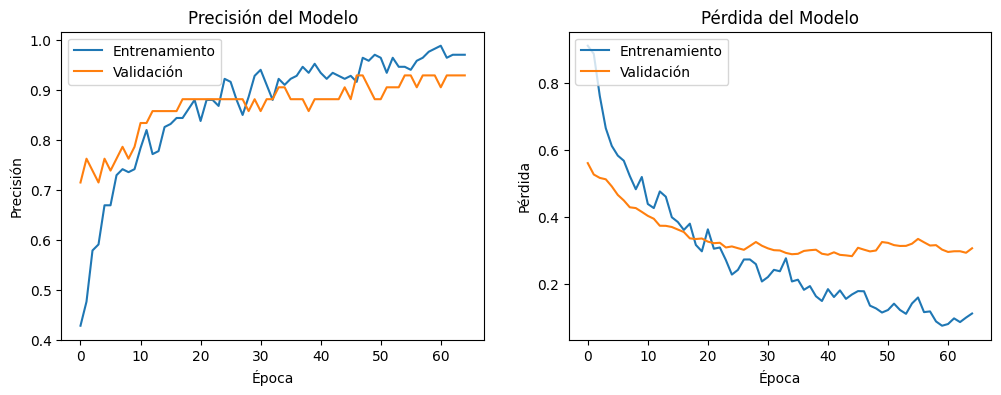

In [36]:
# Graficar valores de precisión de entrenamiento y validación
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Graficar valores de pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()